# CS4248 Project (Labelled Unreliable News)

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
import re
from matplotlib import pyplot as plt

class NewsClassifier:
    def __init__(self, path='./raw_data/fulltrain.csv', remove_punctuation=False):
        # Read CSV file in
        df = pd.read_csv(path, header=None)
        self.df = df
        self.remove_punctuation = remove_punctuation
        #lemmatizer
        self.lemmatizer = WordNetLemmatizer()

        # Total number of labels for each - Dictionary {1 2 3 4}
        self.label_counts = self.count_labels()
        # Total number of tokens for each label in total
        self.raw_word_count_dict = {1: 0, 2: 0, 3: 0, 4: 0}
        # Total number of words without stopwords
        self.stopword_count_dict = {1: 0, 2: 0, 3: 0, 4: 0}

        # Stopwords
        self.stopwords_set = set(stopwords.words('english'))
        # Vocabulary with counts
        self.satire_vocab_dictionary = defaultdict(lambda: 0)
        self.hoax_vocab_dictionary = defaultdict(lambda: 0)
        self.propaganda_vocab_dictionary = defaultdict(lambda: 0)
        self.reliable_vocab_dictionary = defaultdict(lambda: 0)
        # Tagged words dictionary
        self.satire_pos_dictionary = defaultdict(lambda: 0)
        self.hoax_pos_dictionary = defaultdict(lambda: 0)
        self.propaganda_pos_dictionary = defaultdict(lambda: 0)
        self.reliable_pos_dictionary = defaultdict(lambda: 0)
    
    def tabulate_and_print_data(self):
        # Print out all the acquired data
        print()
        print('Raw total count - Total number of words for each label')
        print(self.raw_word_count_dict)
        print('Raw stopword count - Total number of stop words for each label')
        print(self.stopword_count_dict)
        # Calculate averages
        average_stop_to_word_ratio = {}
        for key, value in self.label_counts.items():
            self.raw_word_count_dict[key] /= value
            self.stopword_count_dict[key] /= value
            average_stop_to_word_ratio[key] = self.stopword_count_dict[key] / self.raw_word_count_dict[key]
        print('Average number of words per article')
        print(self.raw_word_count_dict)
        print('Average number of stop words per article')
        print(self.stopword_count_dict)
        print('Ratio average stop words to average words per article')
        print(average_stop_to_word_ratio)
        print()

        print('===== Vocabulary =====')
        length_satire_vocab = len(self.satire_vocab_dictionary)
        length_hoax_vocab = len(self.hoax_vocab_dictionary)
        length_propaganda_vocab = len(self.propaganda_vocab_dictionary)
        length_reliable_vocab = len(self.reliable_vocab_dictionary)
        unique_vocab_lengths = [length_satire_vocab, length_hoax_vocab, length_propaganda_vocab, length_reliable_vocab]
        print('Unique vocabulary for satire, hoax, propaganda and reliable')
        print(unique_vocab_lengths)
        print('Ratio unique vocab to all words')
        print('Satire: ' + str((unique_vocab_lengths[0] / self.raw_word_count_dict[1])))
        print('Hoax: ' + str((unique_vocab_lengths[1] / self.raw_word_count_dict[2])))
        print('Propaganda: ' + str((unique_vocab_lengths[2] / self.raw_word_count_dict[3])))
        print('Reliable: ' + str((unique_vocab_lengths[3] / self.raw_word_count_dict[4])))
        print('Sorting dictionaries...')
        sorted_satire = sorted(self.satire_vocab_dictionary.items(), key=lambda x: x[1], reverse=True)
        sorted_hoax = sorted(self.hoax_vocab_dictionary.items(), key=lambda x: x[1], reverse=True)
        sorted_propaganda = sorted(self.propaganda_vocab_dictionary.items(), key=lambda x: x[1], reverse=True)
        sorted_reliable = sorted(self.reliable_vocab_dictionary.items(), key=lambda x: x[1], reverse=True)
        print('Sorting done!')
        # Get top 100 most common words
        sorted_satire = sorted_satire[:500]
        sorted_hoax = sorted_hoax[:500]
        sorted_propaganda = sorted_propaganda[:500]
        sorted_reliable = sorted_reliable[:500]
        print('=== Top 100 most common words: ===')
        print('Satire:')
        print(sorted_satire)
        print('Hoax:')
        print(sorted_hoax)
        print('Propaganda:')
        print(sorted_propaganda)
        print('Reliable:')
        print(sorted_reliable)
        print()

        print('===== Part-Of-Speech (POS) Tagging =====')
        sorted_pos_satire = self.split_tuple_data_to_list(sorted(self.satire_pos_dictionary.items(), key=lambda x: x[1], reverse=True))
        sorted_pos_hoax = self.split_tuple_data_to_list(sorted(self.hoax_pos_dictionary.items(), key=lambda x: x[1], reverse=True))
        sorted_pos_propaganda = self.split_tuple_data_to_list(sorted(self.propaganda_pos_dictionary.items(), key=lambda x: x[1], reverse=True))
        sorted_pos_reliable = self.split_tuple_data_to_list(sorted(self.reliable_pos_dictionary.items(), key=lambda x: x[1], reverse=True))
        # Plot graphs
        print('POS Breakdown of each label')
        print(self.merge_to_tuple(sorted_pos_satire[0], sorted_pos_satire[1]))
        self.plot_bar_graph(sorted_pos_satire[0], sorted_pos_satire[1], 'Satire POS Tagging', 'Number', 'Type')
        print(self.merge_to_tuple(sorted_pos_hoax[0], sorted_pos_hoax[1]))
        self.plot_bar_graph(sorted_pos_hoax[0], sorted_pos_hoax[1], 'Hoax POS Tagging', 'Number', 'Type')
        print(self.merge_to_tuple(sorted_pos_propaganda[0], sorted_pos_propaganda[1]))
        self.plot_bar_graph(sorted_pos_propaganda[0], sorted_pos_propaganda[1], 'Propaganda POS Tagging', 'Number', 'Type')
        print(self.merge_to_tuple(sorted_pos_reliable[0], sorted_pos_reliable[1]))
        self.plot_bar_graph(sorted_pos_reliable[0], sorted_pos_reliable[1], 'Reliable POS Tagging', 'Number', 'Type')

        print()
        print('POS Breakdown of top 100 words for each label')
        # Get POS of top 100 words
        sorted_top_pos_satire = self.split_tuple_data_to_list(sorted(self.get_pos_of_top_words(sorted_satire).items(), key=lambda x: x[1], reverse=True))
        sorted_top_pos_hoax = self.split_tuple_data_to_list(sorted(self.get_pos_of_top_words(sorted_hoax).items(), key=lambda x: x[1], reverse=True))
        sorted_top_pos_propaganda = self.split_tuple_data_to_list(sorted(self.get_pos_of_top_words(sorted_propaganda).items(), key=lambda x: x[1], reverse=True))
        sorted_top_pos_reliable = self.split_tuple_data_to_list(sorted(self.get_pos_of_top_words(sorted_reliable).items(), key=lambda x: x[1], reverse=True))
        # Plot graphs
        print(self.merge_to_tuple(sorted_top_pos_satire[0], sorted_top_pos_satire[1]))
        self.plot_bar_graph(sorted_top_pos_satire[0], sorted_top_pos_satire[1], 'Satire POS Tagging', 'Type', 'Number')
        print(self.merge_to_tuple(sorted_top_pos_hoax[0], sorted_top_pos_hoax[1]))
        self.plot_bar_graph(sorted_top_pos_hoax[0], sorted_top_pos_hoax[1], 'Hoax POS Tagging', 'Type', 'Number')
        print(self.merge_to_tuple(sorted_top_pos_propaganda[0], sorted_top_pos_propaganda[1]))
        self.plot_bar_graph(sorted_top_pos_propaganda[0], sorted_top_pos_propaganda[1], 'Propaganda POS Tagging', 'Type', 'Number')
        print(self.merge_to_tuple(sorted_top_pos_reliable[0], sorted_top_pos_reliable[1]))
        self.plot_bar_graph(sorted_top_pos_reliable[0], sorted_top_pos_reliable[1], 'Reliable POS Tagging', 'Type', 'Number')

    def get_pos_of_top_words(self, top_word_list):
        words = []
        for word in top_word_list:
            words.append(word[0])
        tagged_words = nltk.pos_tag(words)
        pos_dict = defaultdict(lambda: 0)
        for tagged_word in tagged_words:
            pos_dict[tagged_word[1]] += 1
        return pos_dict
    
    def merge_to_tuple(self, data1, data2):
        combined_data = []
        for i in range(0, len(data1)):
            combined_data.append((data1[i], data2[i]))
        return combined_data

    def split_tuple_data_to_list(self, datalist):
        x_axis = []
        y_axis = []
        for data in datalist:
            x_axis.append(data[0])
            y_axis.append(data[1])
        return (x_axis, y_axis)
    
    # Pass in lists as x and y
    def plot_bar_graph(self, x, y, title, xlabel, ylabel):
        fig = plt.figure(figsize = (17, 12))
        plt.rcParams['text.color'] = 'white'
        plt.bar(x, y, color ='blue', width = 0.6)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.show()

    def get_data(self):
        # Copy dataframe
        df = self.df
        # Do the actual data processing
        for i, row in df.iterrows():
            print('Parsing row number: ' + str(i), end = "\r")
            label = int(row[0])
            text = row[1]

            # List of tokens for the sentence
            tokens = self.tokenise_text(text)
            self.raw_word_count_dict[label] += len(tokens)

            # Will filter out all punctuation - Punctuation is important in this context (!, ? has sentiment)
            if self.remove_punctuation:
                depunctuated_tokens = []
                for token in tokens:
                    if re.match(r'^[\W|_]*$', token):
                        continue
                    depunctuated_tokens.append(token)
                tokens = depunctuated_tokens

            # Can think of doing normalisation/stemming over here before removing stopwords
            # Look at ratio of POS words in each sentence
            # Look at nouns/verbs/names - Look for implication words?
            tagged_tokens = nltk.pos_tag(tokens)
            self.count_pos_tags(tagged_tokens, label)

            # Can also look at counting negative/positive sentiment - 'nt and 's not really present in propaganda
            
            # Count and remove stopwords
            count_and_remove_stopword_result = self.count_and_remove_stopwords(tokens)
            self.stopword_count_dict[label] += count_and_remove_stopword_result[0]
            tokens_no_stopwords = count_and_remove_stopword_result[1]
            # tokens_no_stopwords = self.lemmatize_words(tokens_no_stopwords)
            self.update_vocabulary(label, tokens_no_stopwords)

    def lemmatize_words(self, tokens):
        lemmatized_words = []
        for word in tokens:
            lemmatized_words.append(self.lemmatizer.lemmatize(word))
        return lemmatized_words


    def count_pos_tags(self, tagged_tokens, label):
        for token in tagged_tokens:
            tag = token[1]
            if label == 1:
                self.satire_pos_dictionary[tag] += 1
            elif label == 2:
                self.hoax_pos_dictionary[tag] += 1
            elif label == 3:
                self.propaganda_pos_dictionary[tag] += 1
            elif label == 4:
                self.reliable_pos_dictionary[tag] += 1
    
    # Counts the number of each label in the dataset
    def count_labels(self):
        df = self.df
        print('Number of rows: ' + str(df.shape[0]))
        label_count_dict = {1: 0, 2: 0, 3: 0, 4: 0}
        for i, row in df.iterrows():
            label = int(row[0])
            label_count_dict[label] += 1
        print('SATIRE, HOAX, PROPAGANDA, RELIABLE NEWS')
        print(label_count_dict)
        return label_count_dict

    # Updates a set of unique vocabulary
    def update_vocabulary(self, label, tokens):
        if label == 1:
            for token in tokens:
                self.satire_vocab_dictionary[token] += 1
        elif label == 2:
            for token in tokens:
                self.hoax_vocab_dictionary[token] += 1
        elif label == 3:
            for token in tokens:
                self.propaganda_vocab_dictionary[token] += 1
        elif label == 4:
            for token in tokens:
                self.reliable_vocab_dictionary[token] += 1
        pass

    # Returns number of stopwords in a sentence and the set of tokens without stopwords. Uses NLTK stopwords library
    def count_and_remove_stopwords(self, tokens):
        stopword_count = 0
        new_token_list = []
        for token in tokens:
            if token in self.stopwords_set:
                stopword_count += 1
                continue
            new_token_list.append(token)
        return (stopword_count, new_token_list)
    
    # Returns a list of tokens - Utilises NLTK tokenizer. Set to lowercase
    def tokenise_text(self, text):
        raw_text = text.lower()
        return nltk.word_tokenize(raw_text)




In [2]:
news_classifier = NewsClassifier(remove_punctuation=True)
news_classifier.get_data()


Number of rows: 48854
SATIRE, HOAX, PROPAGANDA, RELIABLE NEWS
{1: 14047, 2: 6942, 3: 17870, 4: 9995}



Raw total count - Total number of words for each label
{1: 4756692, 2: 1503592, 3: 18189135, 4: 5052108}
Raw stopword count - Total number of stop words for each label
{1: 1722702, 2: 605984, 3: 7131295, 4: 1786370}
Average number of words per article
{1: 338.62689542251013, 2: 216.59348890809565, 3: 1017.858701734751, 4: 505.4635317658829}
Average number of stop words per article
{1: 122.63842813412117, 2: 87.29242293287237, 3: 399.0651930609961, 4: 178.72636318159078}
Ratio average stop words to average words per article
{1: 0.36216387354909674, 2: 0.4030242246566888, 3: 0.39206344886658984, 4: 0.3535890364972403}

===== Vocabulary =====
Unique vocabulary for satire, hoax, propaganda and reliable
[120142, 36666, 217954, 118431]
Ratio unique vocab to all words
Satire: 354.79166487971054
Hoax: 169.2848671714135
Propaganda: 214.1299176678825
Reliable: 234.3017696771328
Sorting dictionaries...
Sorting done!
=== Top 100 most common words: ===
Satire:
[('said', 34915), ("'s", 34890), ("n'

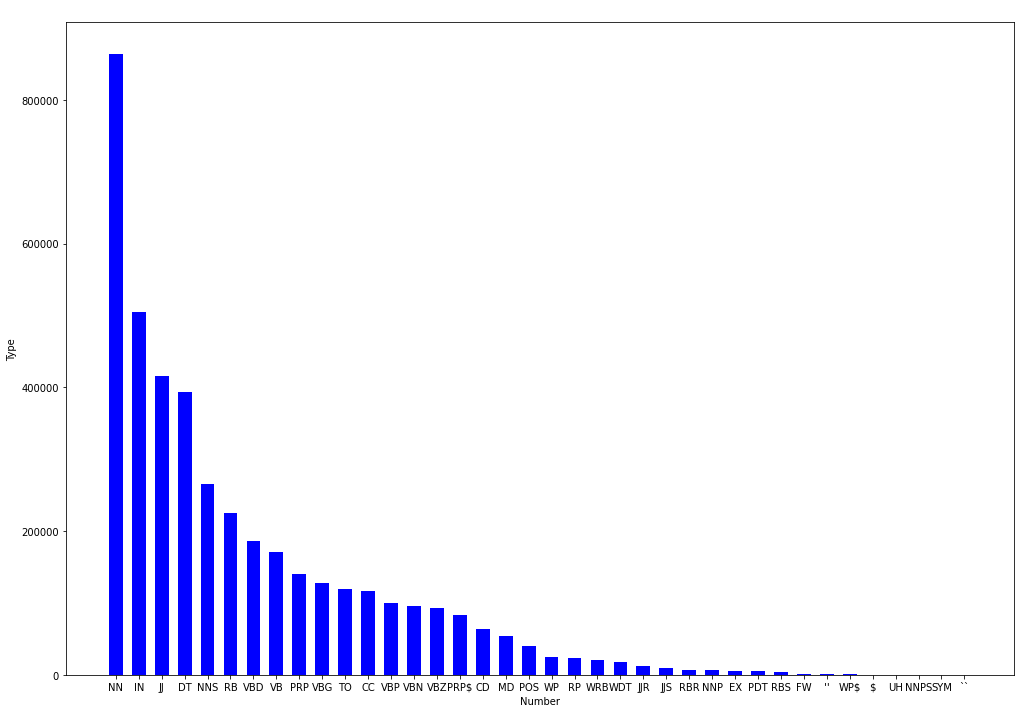

[('NN', 272431), ('IN', 161976), ('DT', 131330), ('JJ', 114267), ('NNS', 87068), ('VB', 63732), ('RB', 61168), ('PRP', 58897), ('VBD', 56168), ('VBZ', 45265), ('TO', 44702), ('VBP', 41035), ('VBG', 40219), ('VBN', 38765), ('CC', 33417), ('PRP$', 28422), ('CD', 16006), ('MD', 13825), ('WP', 11359), ('WRB', 7073), ('RP', 6832), ('WDT', 6625), ('JJR', 2852), ('JJS', 2034), ('RBR', 1661), ('EX', 1518), ('RBS', 844), ('PDT', 744), ('NNP', 484), ('FW', 443), ('POS', 155), ('NNPS', 87), ('$', 77), ('WP$', 66), ('UH', 32), ("''", 6)]


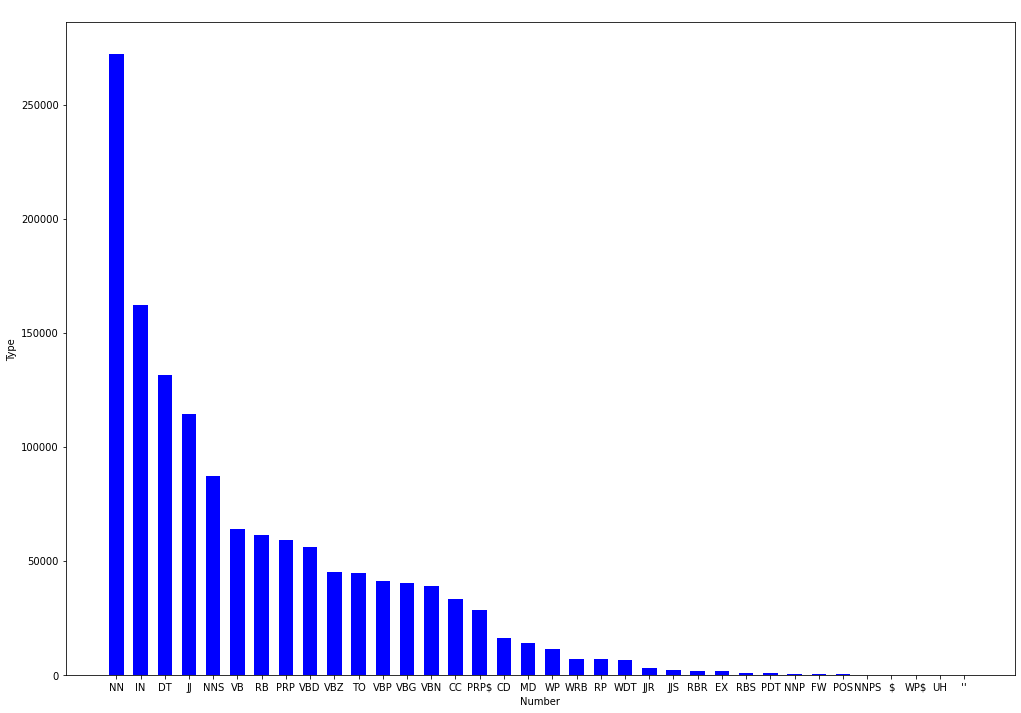

[('NN', 3266661), ('IN', 2019833), ('DT', 1679219), ('JJ', 1623851), ('NNS', 1237802), ('RB', 772932), ('VB', 680153), ('CC', 567843), ('PRP', 518046), ('VBZ', 506927), ('VBP', 499095), ('TO', 459556), ('VBN', 435649), ('VBG', 404848), ('VBD', 387401), ('CD', 266618), ('PRP$', 238128), ('MD', 216899), ('WDT', 102380), ('WP', 87181), ('WRB', 85692), ('RP', 65910), ('JJR', 55030), ('JJS', 35663), ('RBR', 28902), ('EX', 28649), ('PDT', 14614), ('RBS', 11436), ('FW', 6284), ('NNP', 6080), ('WP$', 2216), ('$', 1433), ('NNPS', 729), ('UH', 630), ('POS', 66), ("''", 33), ('SYM', 22)]


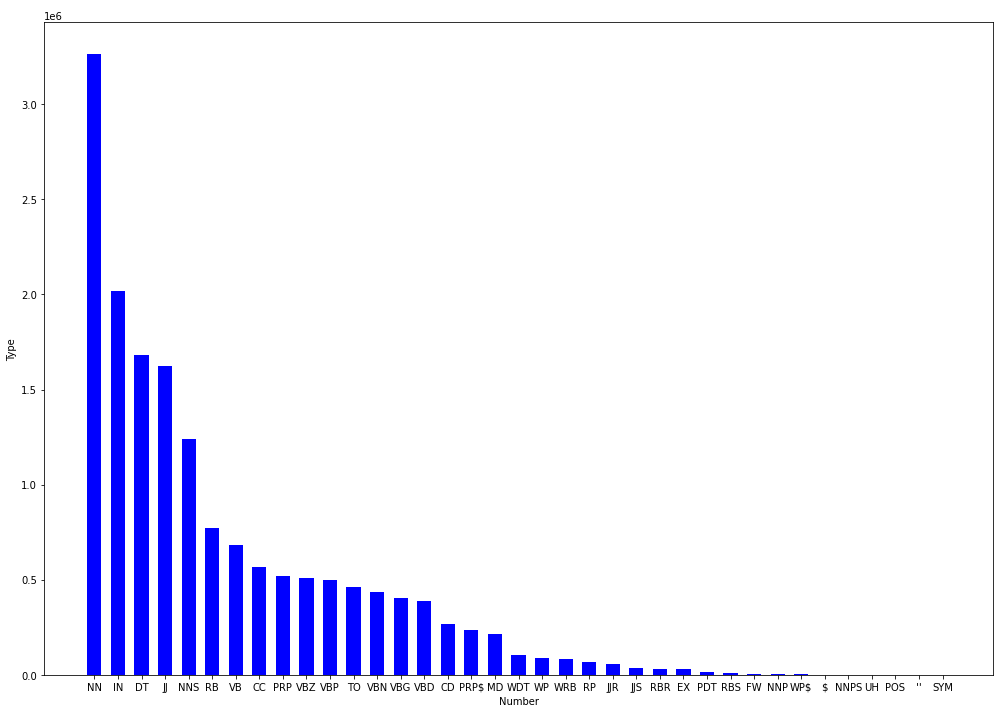

[('NN', 986432), ('IN', 563488), ('DT', 451347), ('JJ', 442813), ('NNS', 326695), ('VBD', 197981), ('VB', 159068), ('RB', 158282), ('CC', 136665), ('CD', 122628), ('TO', 121306), ('VBN', 113438), ('PRP', 112300), ('VBZ', 103379), ('VBG', 98202), ('VBP', 87180), ('PRP$', 55282), ('MD', 51450), ('POS', 50617), ('WDT', 25155), ('WP', 19808), ('JJR', 16411), ('RP', 16373), ('WRB', 15586), ('JJS', 10782), ('NNP', 7884), ('RBR', 7547), ('EX', 6486), ('PDT', 3355), ('RBS', 2966), ('FW', 1811), ("''", 1600), ('WP$', 1214), ('$', 847), ('NNPS', 400), ('UH', 54), ('SYM', 9), ('``', 1)]


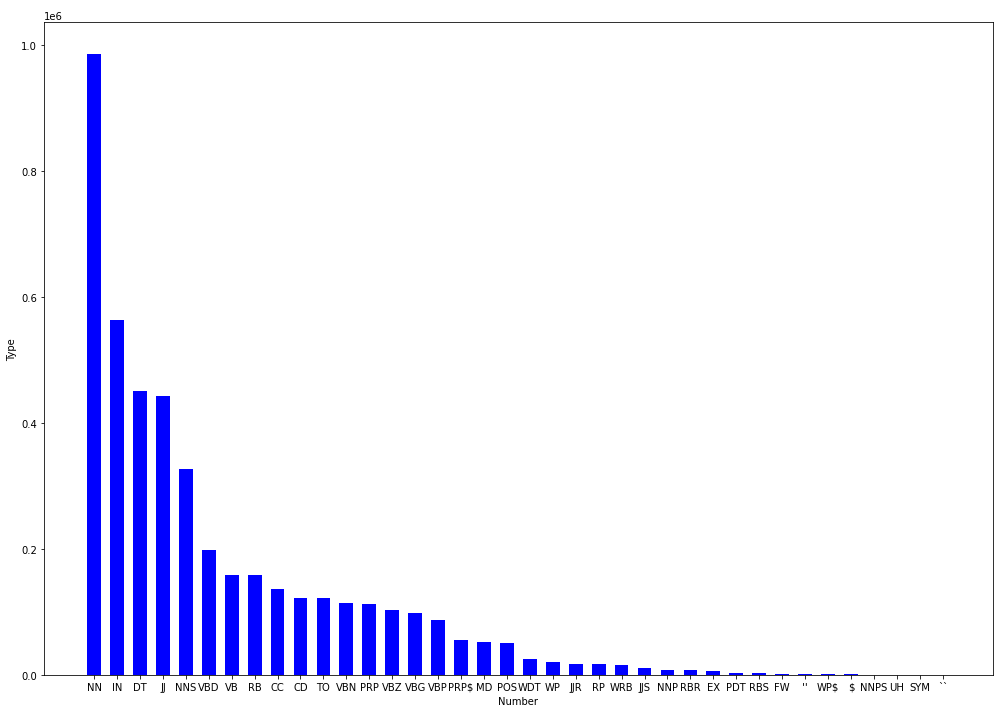


POS Breakdown of top 100 words for each label
[('NN', 171), ('JJ', 78), ('RB', 46), ('NNS', 40), ('VBD', 24), ('VBP', 24), ('IN', 20), ('VBG', 20), ('VBN', 19), ('CD', 13), ('VB', 12), ('POS', 8), ('VBZ', 8), ('MD', 7), ('RBR', 3), ('DT', 2), ('PRP', 1), ('JJS', 1), ('WP$', 1), ('JJR', 1), ('CC', 1)]


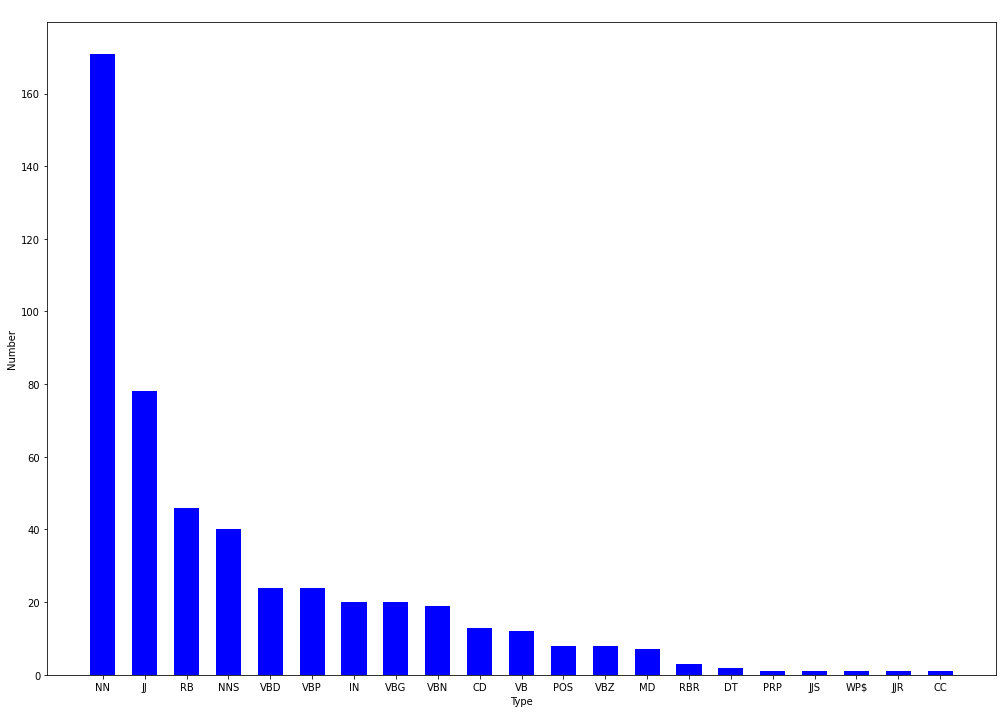

[('NN', 181), ('JJ', 94), ('NNS', 50), ('RB', 33), ('VBD', 30), ('VBP', 28), ('VBG', 20), ('VBN', 15), ('IN', 13), ('VBZ', 10), ('VB', 8), ('CD', 7), ('MD', 5), ('DT', 2), ('PRP', 1), ('NNP', 1), ('JJS', 1), ('RBR', 1)]


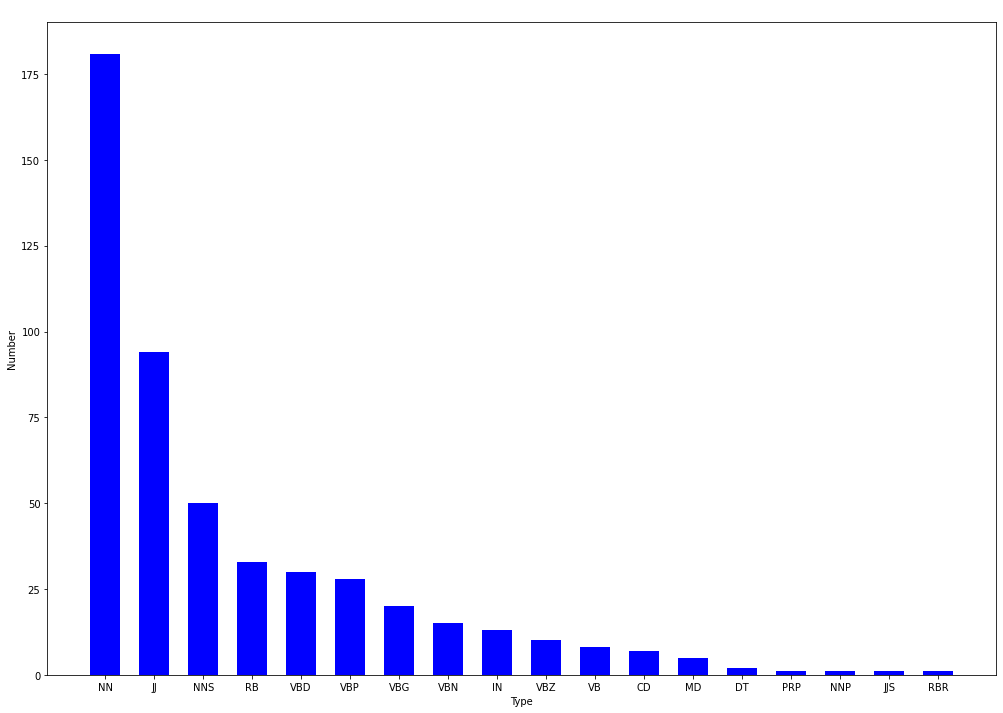

[('NN', 182), ('JJ', 108), ('NNS', 51), ('RB', 35), ('VBP', 25), ('IN', 16), ('CD', 14), ('VBN', 14), ('VBG', 12), ('VBD', 11), ('VB', 10), ('VBZ', 8), ('MD', 5), ('RBR', 3), ('DT', 2), ('JJS', 2), ('PRP', 1), ('CC', 1)]


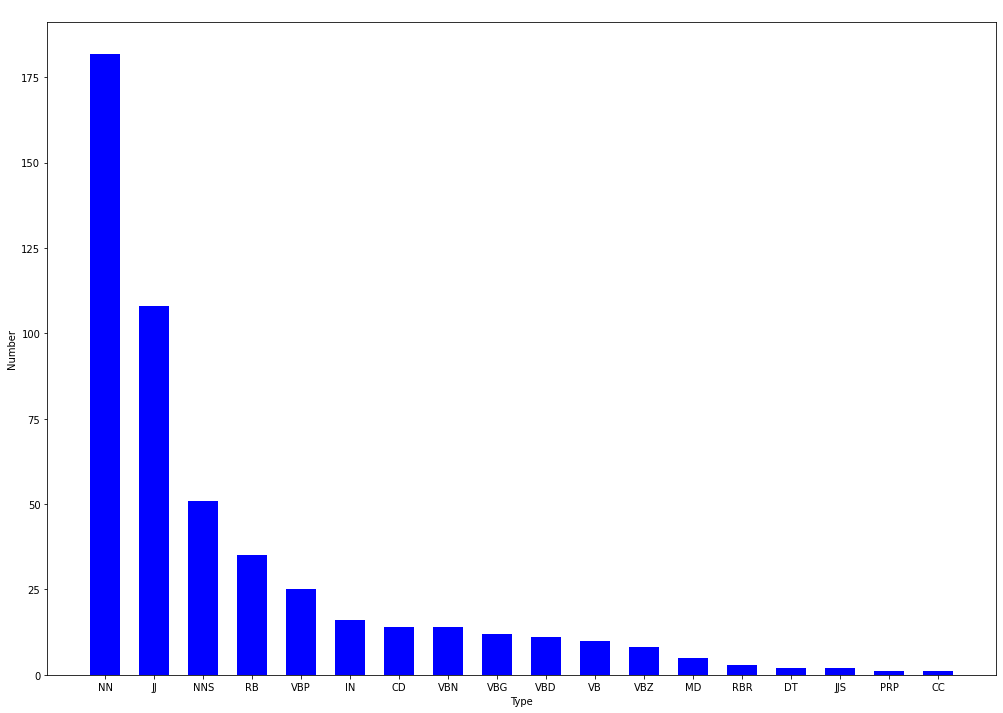

[('NN', 176), ('JJ', 96), ('NNS', 50), ('RB', 30), ('VBD', 24), ('CD', 23), ('VBP', 20), ('IN', 17), ('VBG', 13), ('VBN', 13), ('VB', 10), ('MD', 8), ('POS', 3), ('VBZ', 3), ('JJS', 3), ('DT', 2), ('JJR', 2), ('RBR', 2), ('CC', 1), ('PRP', 1), ('RP', 1), ('RBS', 1), ('WP$', 1)]


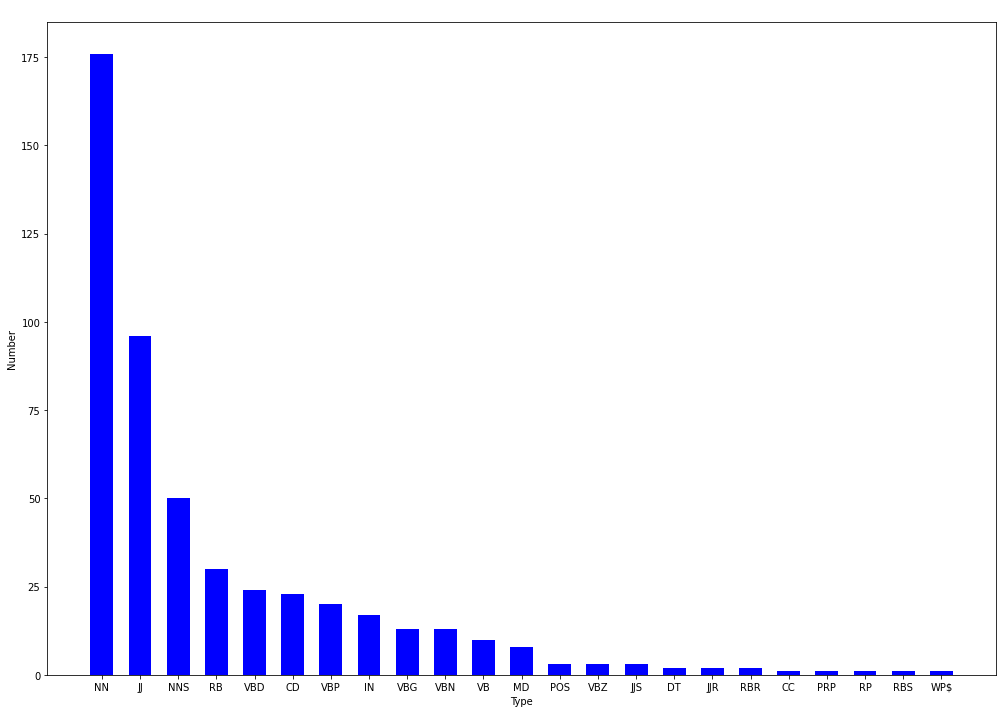

In [3]:
# Print out data
news_classifier.tabulate_and_print_data()